# King County Housing Analysis

---

**Import Necessary Libraries**

In [1]:
#data cleaning and stats
import pandas as pd
import numpy as np

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#normality check
import scipy.stats as stats
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

#data transformation
from sklearn import preprocessing

#linear regression (sklearn and statsmodels)
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols

#model evaluation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from math import sqrt
from functions import linreg_summary, ols_linreg_summary, k_folds_cv, normality_check
from sklearn.model_selection import cross_val_score

---

## Data Understanding

In [2]:
df = pd.read_csv('data/kingcounty.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
#inspect data types and total value counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


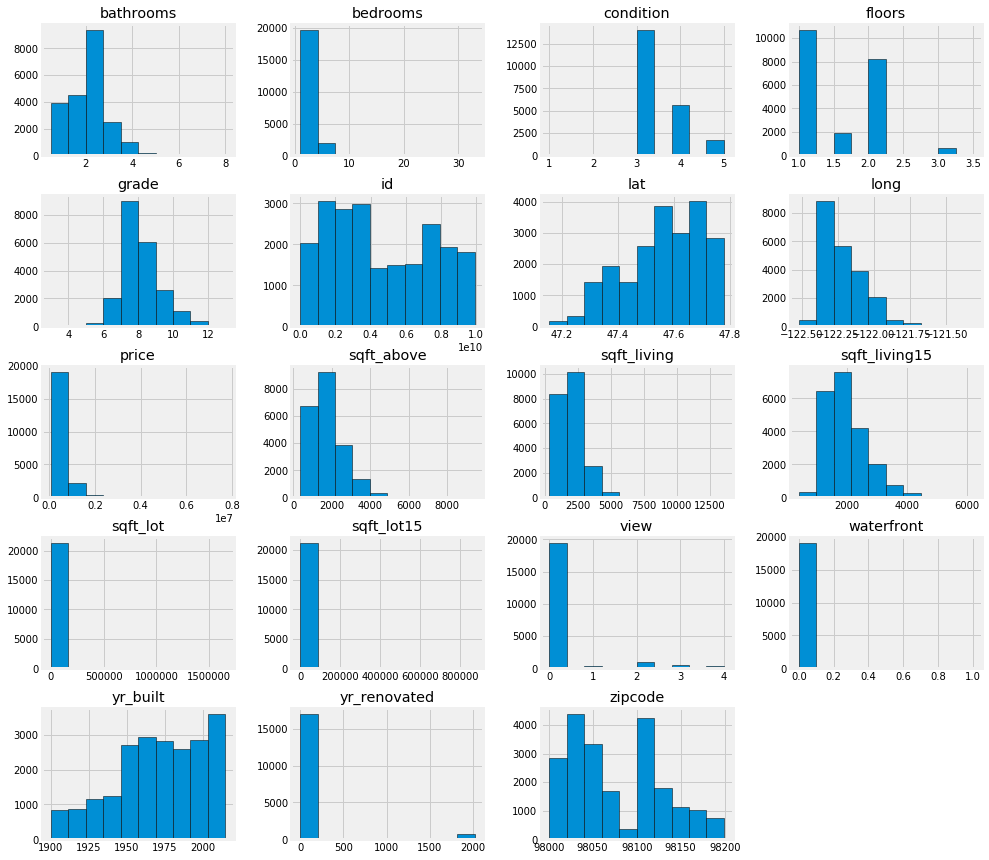

In [4]:
#distribution visualization
df.hist(figsize=(15,15), edgecolor = 'black');

In [5]:
#inspect for any columns with null values
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

**Initial data analysis:**
- 'waterfront', 'view', and 'yr_renovated' have null values
- 'yr_renovated' also has a significant amount of missing values represented with a placeholder value 0
- several variables have non-normal distributions, including target variable 'price'
- several variables are categorical variables
- variance in magnitudes of several variable values 

In [6]:
#display value count of placeholder value 
df['yr_renovated'].value_counts() 

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
2000.0       29
2005.0       29
1990.0       22
2004.0       22
2009.0       21
1989.0       20
2006.0       20
2002.0       17
1991.0       16
1998.0       16
1984.0       16
1999.0       15
2008.0       15
2010.0       15
2001.0       15
1983.0       15
2015.0       14
1985.0       14
1986.0       14
1987.0       14
1994.0       14
1992.0       13
1993.0       12
1997.0       12
1995.0       12
          ...  
1975.0        5
1964.0        5
1969.0        4
1963.0        4
1973.0        4
1981.0        4
1965.0        4
1978.0        3
1960.0        3
1958.0        3
1956.0        3
1955.0        3
1945.0        3
1972.0        3
1967.0        2
1957.0        2
1940.0        2
1974.0        2
1962.0        2
1953.0        1
1950.0        1
1934.0        1
1944.0        1
1976.0        1
1948.0        1
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Leng

In [7]:
#display percentage of column with null values
waterfront_perc_missing = round((df['waterfront'].isna().sum()/len(df['waterfront']))*100, 2)
view_perc_missing = round((df['view'].isna().sum()/len(df.view))*100, 2)
yr_renovated_perc_missing = round((df['yr_renovated'].isna().sum()/len(df['yr_renovated']))*100, 2)
yr_renovated_totalperc_missing = round(((df['yr_renovated'].isna().sum()+17011)/
                                        len(df['yr_renovated']))*100, 2)

print(f"'waterfront' null percentage: {waterfront_perc_missing}")
print(f"'view' null percentage: {view_perc_missing}")
print(f"'yr_renovated' null percentage: {yr_renovated_perc_missing}")
print(f"'yr_renovated' null + placeholder values: {yr_renovated_totalperc_missing}")

'waterfront' null percentage: 11.0
'view' null percentage: 0.29
'yr_renovated' null percentage: 17.79
'yr_renovated' null + placeholder values: 96.56


---

## Data Preparation

1. Drop 'yr_renovated' column because 96.56% of its data is missing.
2. Replace null values in 'waterfront' with the most common value since the value counts are significantly different.
3. Drop rows with missing values for 'view' column since it is only 0.29% of the dataset.
4. Conduct further data analysis.

In [8]:
df = df.drop('yr_renovated', axis=1)

# replace null values in "waterfront" with most common value 0
df['waterfront'] = df['waterfront'].fillna(0)

# drop null values in 'view' column
df = df.dropna(subset=['view'])

In [9]:
#sanity check
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 20 columns):
id               21534 non-null int64
date             21534 non-null object
price            21534 non-null float64
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_living      21534 non-null int64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       21534 non-null float64
view             21534 non-null float64
condition        21534 non-null int64
grade            21534 non-null int64
sqft_above       21534 non-null int64
sqft_basement    21534 non-null object
yr_built         21534 non-null int64
zipcode          21534 non-null int64
lat              21534 non-null float64
long             21534 non-null float64
sqft_living15    21534 non-null int64
sqft_lot15       21534 non-null int64
dtypes: float64(7), int64(11), object(2)
memory usage: 3.5+ MB


---

**Further data inspection**

In [11]:
#after further inspection, I've discovered another placeholder value '?'
df['sqft_basement'].value_counts().head()

0.0      12798
?          452
600.0      216
500.0      209
700.0      207
Name: sqft_basement, dtype: int64

In [12]:
#replace '?' values with difference in sqft_living and sqft_above
df.loc[df['sqft_basement'] == '?', 'sqft_basement'] = df['sqft_living'] - df['sqft_above']

In [13]:
#change data type to float
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: float(x))

In [14]:
#drop 'id' column because it is not a predictor
#drop 'lat', 'long', and 'date' for now 
df = df.drop(df[['id', 'date', 'lat', 'long']], axis=1)

In [15]:
#change 'yr_built' column to 'age' of house column
df['age'] = df['yr_built'].apply(lambda x: 2019 - x)
df = df.drop(['yr_built'], axis=1)

**Transform categorical columns for use in Linear Regression model**

In [16]:
# #transform categorical column 'waterfront'
# waterfront_dummies = pd.get_dummies(df["waterfront"], 
#                                     prefix="waterfront", 
#                                     drop_first=True,
#                                    dtype=int)
# df = df.drop(["waterfront"], axis=1)
# df = pd.concat([df, waterfront_dummies], axis=1)

---

### Correlation Visualization

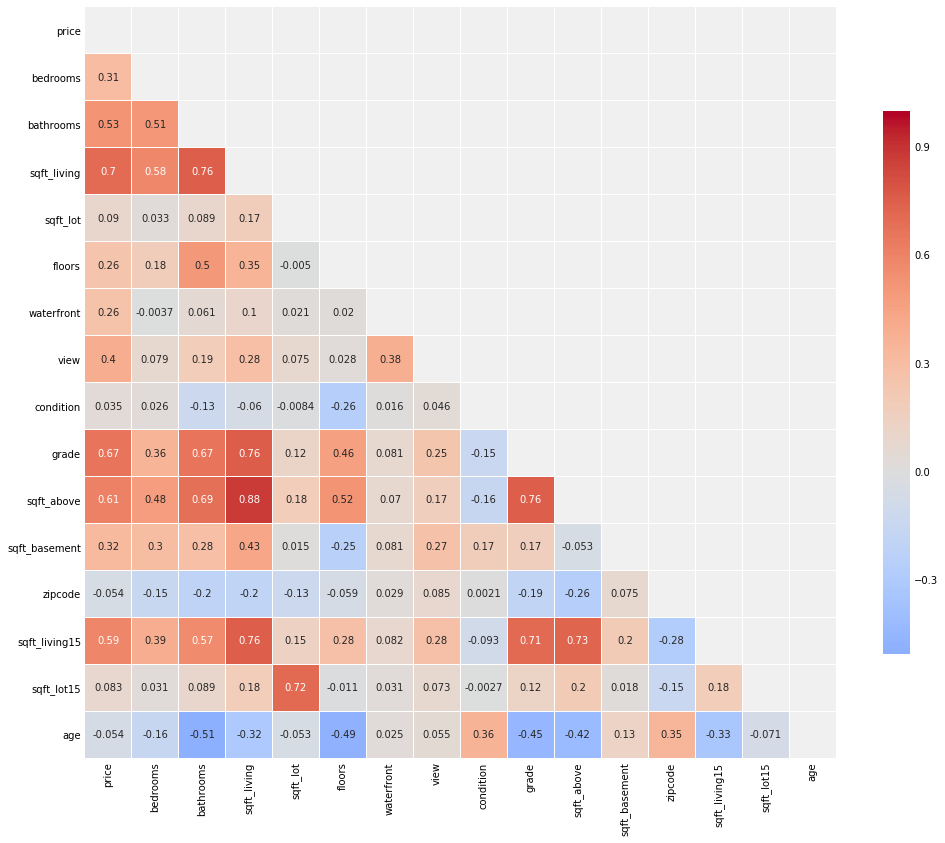

In [17]:
#visualize correlation using heatmap
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 20))

sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5,annot=True, cbar_kws={"shrink": .5});

**For my first model, I will start with variables that are positively correlated with the target variable.**

In [18]:
# create df for first model by dropping variables not positively correlated with 'price'
df_1 = df.drop(df[['zipcode', 'age']], axis=1)

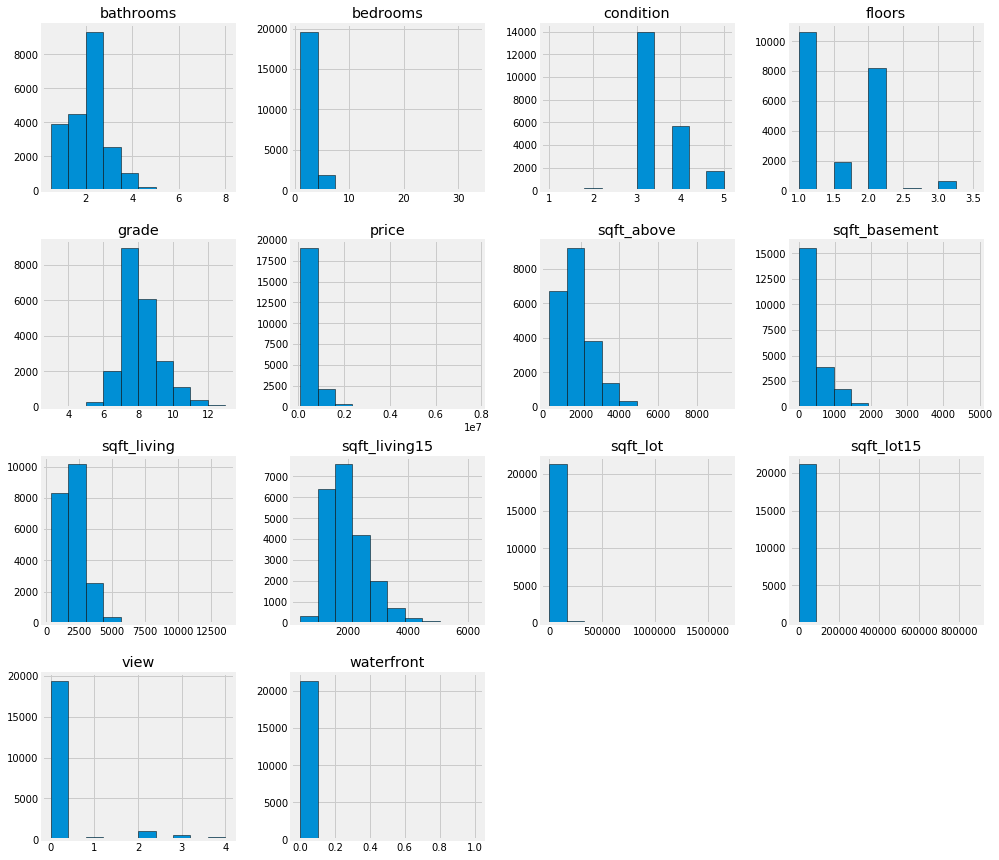

In [19]:
#let's take a look of distributions of selected predictors after preliminary data preparation
df_1.hist(figsize=(15,15), edgecolor = 'black');

---

## Linear Regression Assumption checks <br/>
1. Linearity 
2. Normality (residuals) 
3. Homoscedasticity

bedrooms
[('Jarque-Bera', 1154426.555294989), ('Prob', 0.0), ('Skew', 3.8582623896076913), ('Kurtosis', 38.02974136062947)]
Redisuals MIN: -3506465.56
Redisuals MAX: 6840169.54


<Figure size 432x288 with 0 Axes>

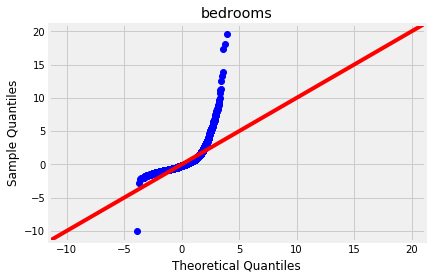

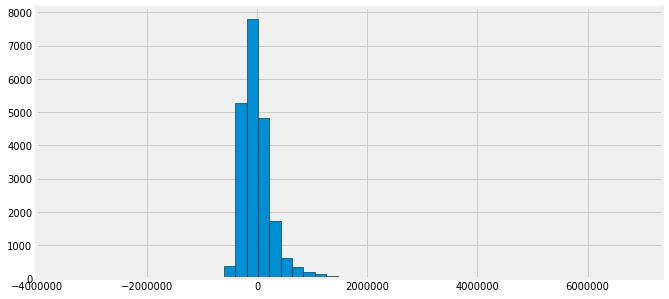

bathrooms
[('Jarque-Bera', 857836.5578051317), ('Prob', 0.0), ('Skew', 3.4214714269944073), ('Kurtosis', 33.15372611067674)]
Redisuals MIN: -1436480.23
Redisuals MAX: 5923715.15


<Figure size 432x288 with 0 Axes>

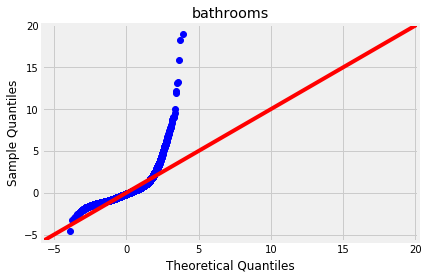

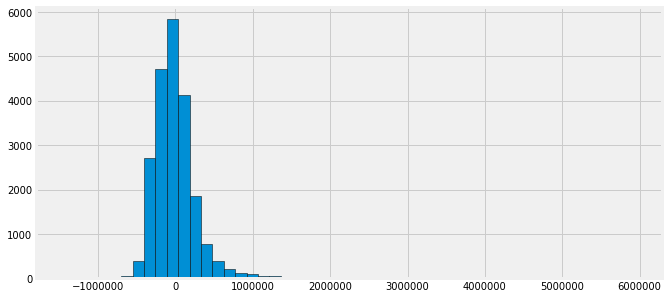

sqft_living
[('Jarque-Bera', 516142.2885372242), ('Prob', 0.0), ('Skew', 2.7805452866970697), ('Kurtosis', 26.330739573364625)]
Redisuals MIN: -1468127.9
Redisuals MAX: 4368970.96


<Figure size 432x288 with 0 Axes>

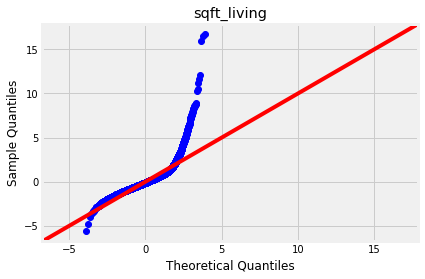

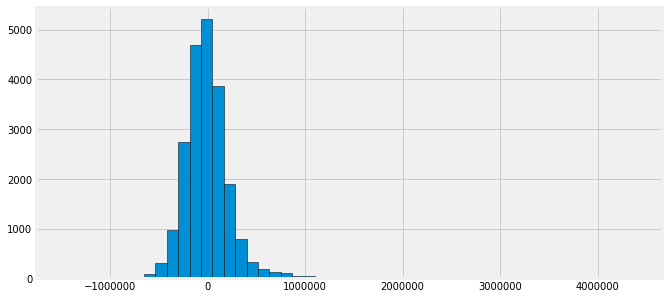

sqft_lot
[('Jarque-Bera', 1100648.8107874435), ('Prob', 0.0), ('Skew', 3.980227256085205), ('Kurtosis', 37.10751399055717)]
Redisuals MIN: -1268845.38
Redisuals MAX: 7149945.42


<Figure size 432x288 with 0 Axes>

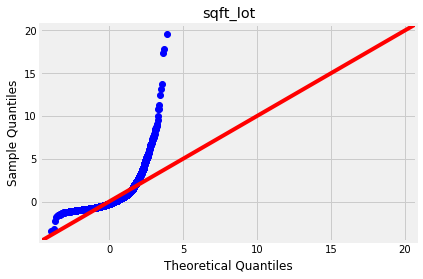

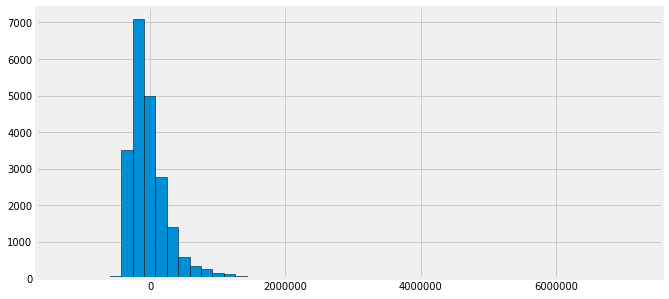

floors
[('Jarque-Bera', 1204740.126098323), ('Prob', 0.0), ('Skew', 4.025791667062309), ('Kurtosis', 38.747375414917116)]
Redisuals MIN: -597554.53
Redisuals MAX: 6984603.09


<Figure size 432x288 with 0 Axes>

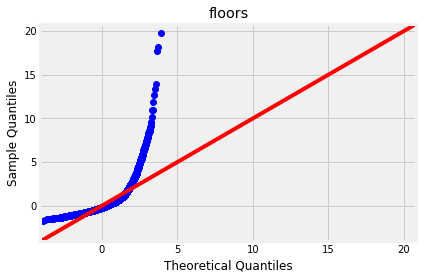

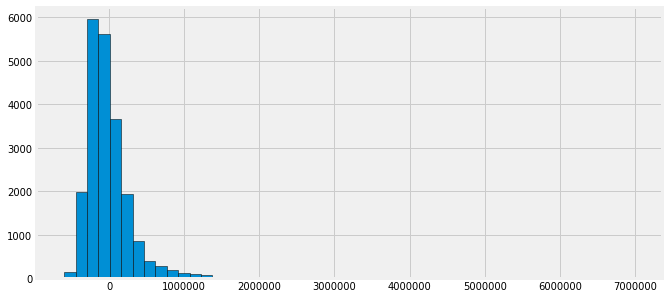

waterfront
[('Jarque-Bera', 905012.3579128587), ('Prob', 0.0), ('Skew', 3.5956892320797853), ('Kurtosis', 33.934371698271846)]
Redisuals MIN: -1407505.86
Redisuals MAX: 7167755.0


<Figure size 432x288 with 0 Axes>

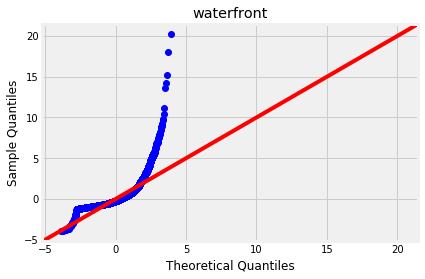

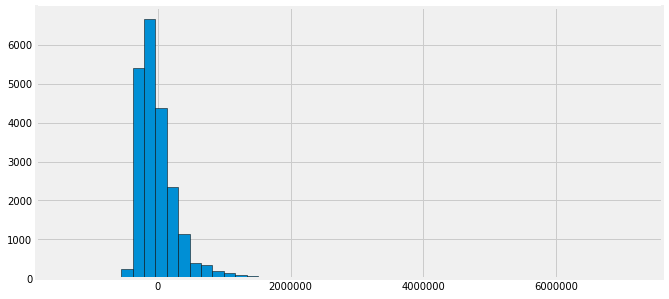

view
[('Jarque-Bera', 1003766.4420889696), ('Prob', 0.0), ('Skew', 3.5912519193098302), ('Kurtosis', 35.666894238543506)]
Redisuals MIN: -1000582.78
Redisuals MAX: 6636609.77


<Figure size 432x288 with 0 Axes>

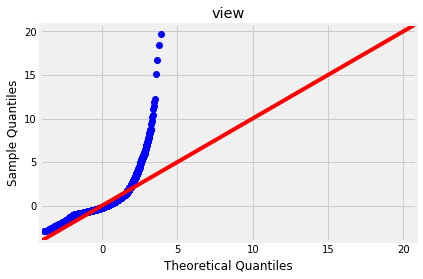

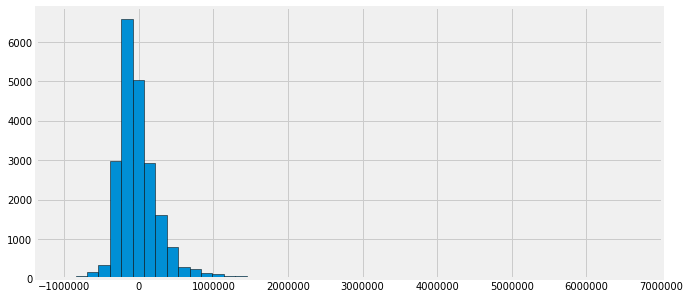

condition
[('Jarque-Bera', 1090709.5200926769), ('Prob', 0.0), ('Skew', 3.976475082304317), ('Kurtosis', 36.94649357560285)]
Redisuals MIN: -462811.35
Redisuals MAX: 7148188.65


<Figure size 432x288 with 0 Axes>

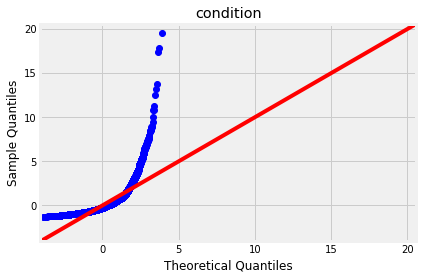

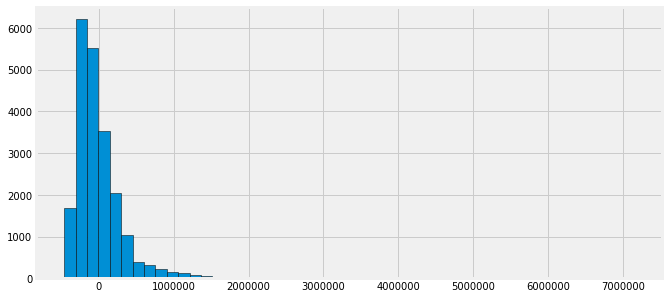

grade
[('Jarque-Bera', 1970129.654682018), ('Prob', 0.0), ('Skew', 4.0217372633227315), ('Kurtosis', 49.16323948064056)]
Redisuals MIN: -817395.74
Redisuals MAX: 6045358.17


<Figure size 432x288 with 0 Axes>

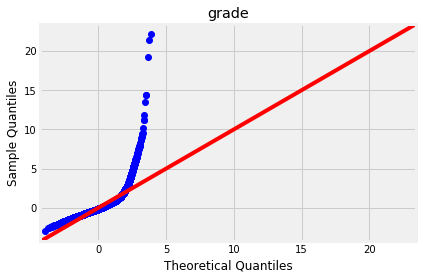

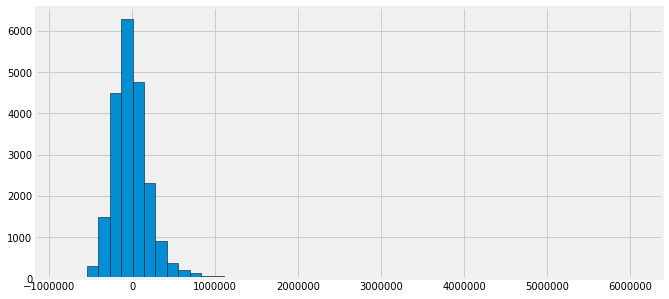

sqft_above
[('Jarque-Bera', 685308.2436162458), ('Prob', 0.0), ('Skew', 3.2120260867558423), ('Kurtosis', 29.87971265694378)]
Redisuals MIN: -910814.43
Redisuals MAX: 5343459.99


<Figure size 432x288 with 0 Axes>

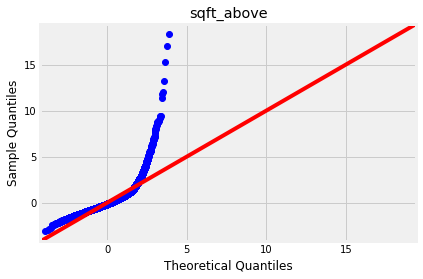

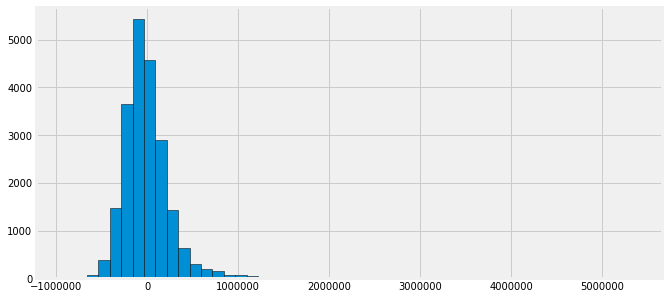

sqft_basement
[('Jarque-Bera', 862520.9799034009), ('Prob', 0.0), ('Skew', 3.662561182252118), ('Kurtosis', 33.12700638454822)]
Redisuals MIN: -599262.83
Redisuals MAX: 6310450.84


<Figure size 432x288 with 0 Axes>

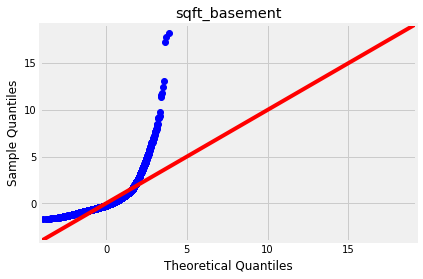

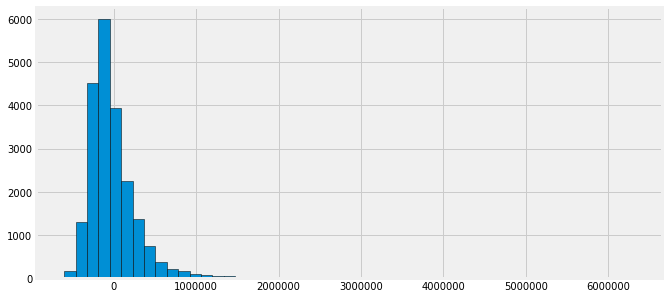

sqft_living15
[('Jarque-Bera', 1851998.0343238688), ('Prob', 0.0), ('Skew', 4.158335538283399), ('Kurtosis', 47.66447687688195)]
Redisuals MIN: -841003.88
Redisuals MAX: 6548967.03


<Figure size 432x288 with 0 Axes>

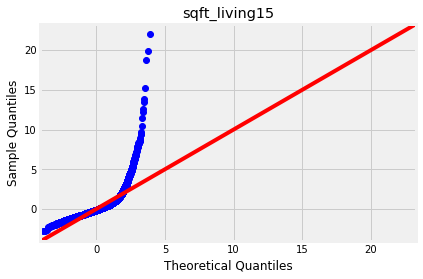

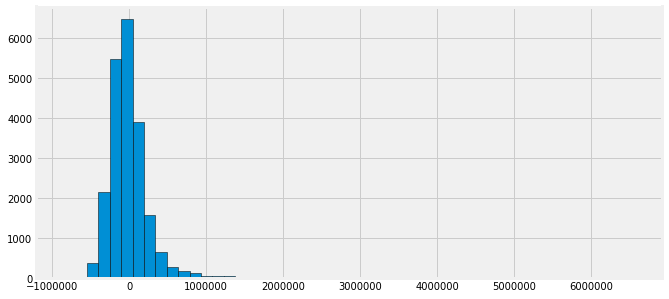

sqft_lot15
[('Jarque-Bera', 1095785.8109524415), ('Prob', 0.0), ('Skew', 3.977550644108034), ('Kurtosis', 37.0292200353399)]
Redisuals MIN: -783833.78
Redisuals MAX: 7164356.84


<Figure size 432x288 with 0 Axes>

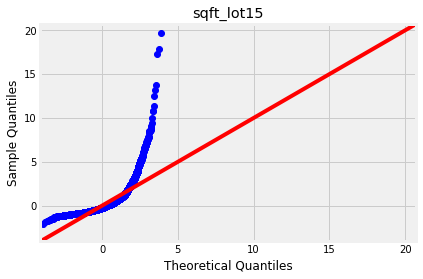

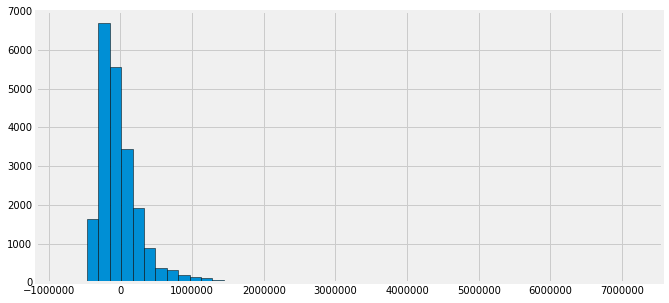

In [20]:
#Conduct normality check
normality_check(df_1)

**Observations:**
1. Based off the qq-plots and histograms, the residuals for all independent variables do not have normal distributions.
2. QQ-plots display an obvious positive skew for all independent variables and can be confirmed with its corresponding histograms.
3. Residuals max is much higher then residuals min.
4. Jarque-Bera score is incredibly high for all independent variables, indicating a non-normal distribution.
5. Skew measure is high indicating positive skewness.
5. Kurtosis for all independent variables are also high, indicating heavy tails.

**Notes**
- Jarque-Bera score roughly above 5 indicates residuals are not-normally distributed.
- Skewness lower than -1 or higher than 1 indicates high skewness.
- Kurtosis higher than 3 indicates heavier tails than a normal distribution.

**I will conduct a log-transformation on target variable 'price' and check normality of residuals**

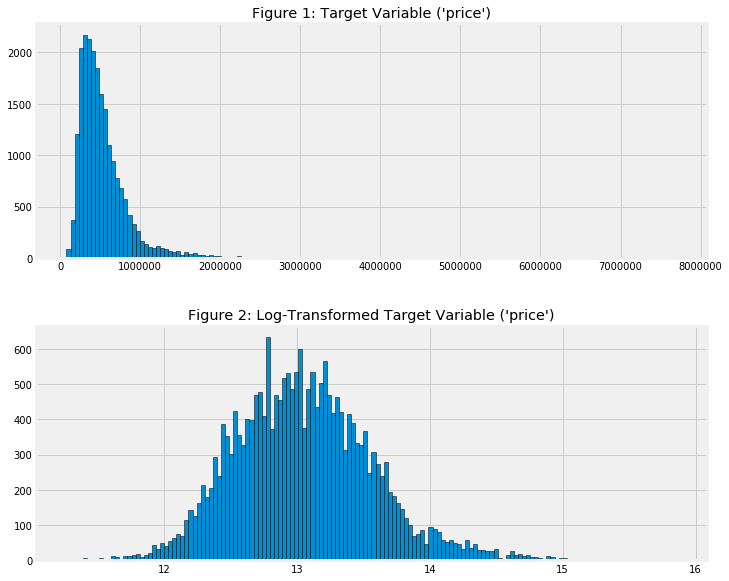

In [21]:
X_log = np.log(df_1['price'])
X = df_1['price']

fig, ax = plt.subplots(2, 1, figsize=(10,8))
fig.tight_layout(h_pad=5)
grid = plt.GridSpec(2, 1, hspace=10)

ax[0].hist(X, bins=150, edgecolor = 'black')
ax[0].set_title("Figure 1: Target Variable ('price')")
ax[1].hist(X_log, bins=150, edgecolor = 'black')
ax[1].set_title("Figure 2: Log-Transformed Target Variable ('price')")
plt.show()

bedrooms
[('Jarque-Bera', 1453.2305810130351), ('Prob', 0.0), ('Skew', 0.2895224161980989), ('Kurtosis', 4.133294602873283)]
Redisuals MIN: -5.45
Redisuals MAX: 2.41


<Figure size 432x288 with 0 Axes>

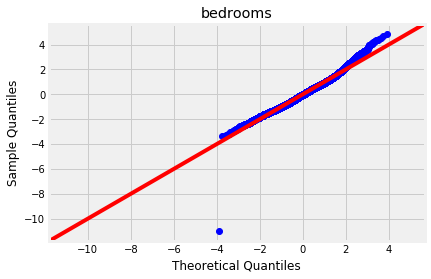

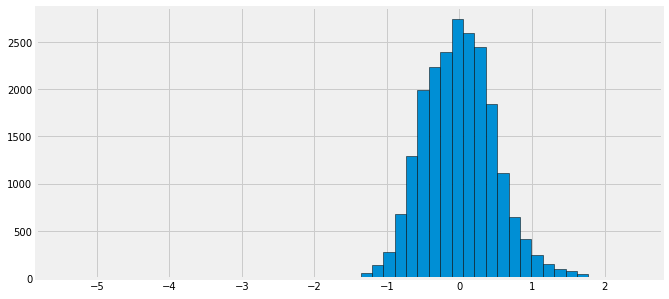

bathrooms
[('Jarque-Bera', 198.31571367687943), ('Prob', 8.635548700008987e-44), ('Skew', 0.23267251086321222), ('Kurtosis', 3.066934007883188)]
Redisuals MIN: -2.06
Redisuals MAX: 2.09


<Figure size 432x288 with 0 Axes>

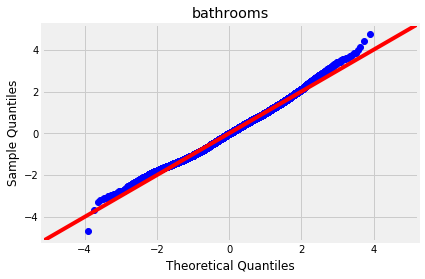

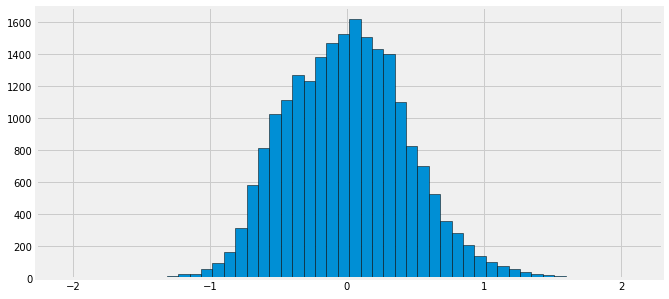

sqft_living
[('Jarque-Bera', 3.6902758157188464), ('Prob', 0.15800352945854856), ('Skew', 0.029200586074116436), ('Kurtosis', 2.9735013836714903)]
Redisuals MIN: -2.98
Redisuals MAX: 1.28


<Figure size 432x288 with 0 Axes>

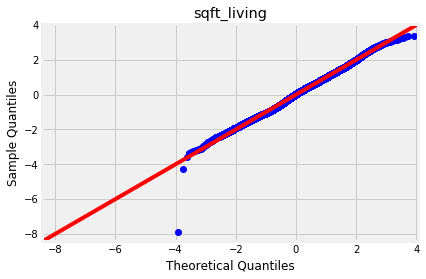

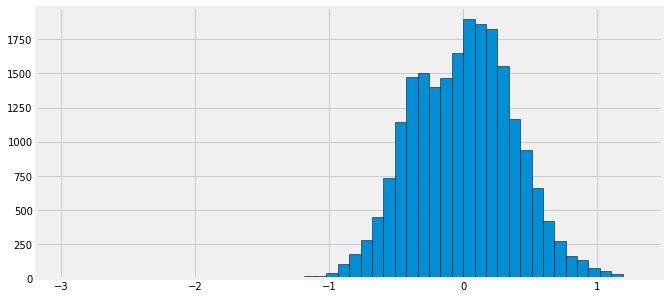

sqft_lot
[('Jarque-Bera', 1080.7913482180995), ('Prob', 2.0377020860479333e-235), ('Skew', 0.42224043729281535), ('Kurtosis', 3.701007794447613)]
Redisuals MIN: -2.36
Redisuals MAX: 2.79


<Figure size 432x288 with 0 Axes>

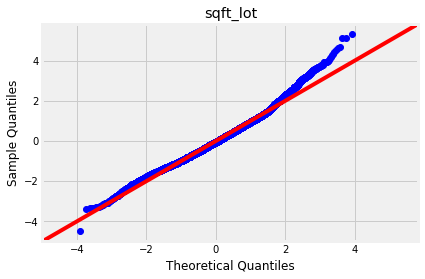

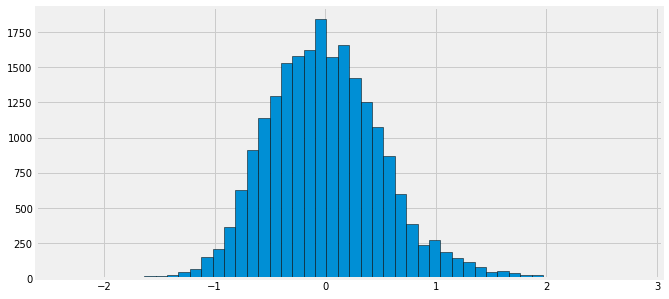

floors
[('Jarque-Bera', 1009.6642048716487), ('Prob', 5.678107683240074e-220), ('Skew', 0.43444103960770053), ('Kurtosis', 3.6085486236935074)]
Redisuals MIN: -1.79
Redisuals MAX: 2.57


<Figure size 432x288 with 0 Axes>

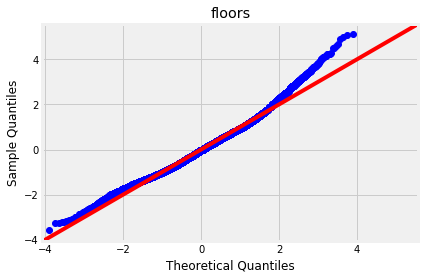

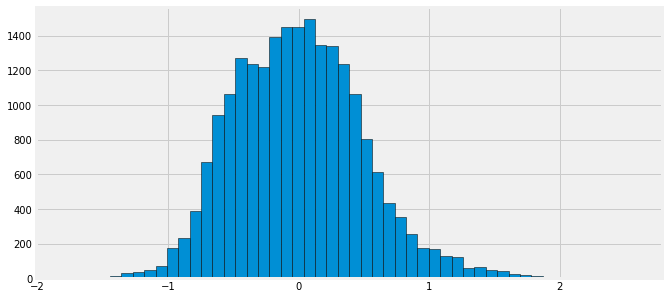

waterfront
[('Jarque-Bera', 701.9681659498474), ('Prob', 3.7115005403566824e-153), ('Skew', 0.3566532956159612), ('Kurtosis', 3.523018991423048)]
Redisuals MIN: -1.78
Redisuals MAX: 2.82


<Figure size 432x288 with 0 Axes>

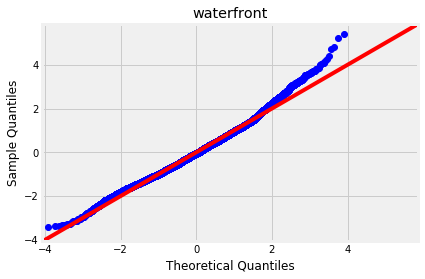

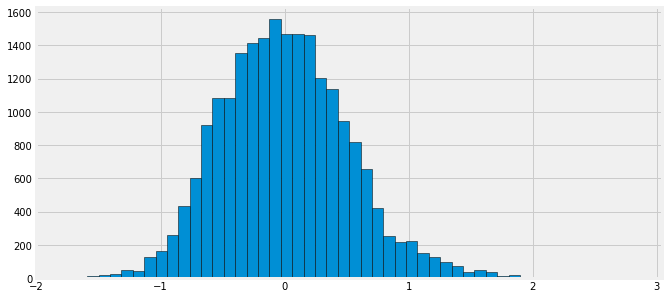

view
[('Jarque-Bera', 410.48508992504134), ('Prob', 7.316363441678062e-90), ('Skew', 0.2633927236405257), ('Kurtosis', 3.4242517300546638)]
Redisuals MIN: -1.76
Redisuals MAX: 2.54


<Figure size 432x288 with 0 Axes>

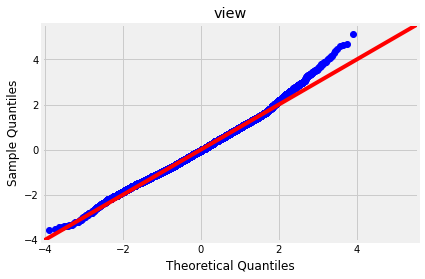

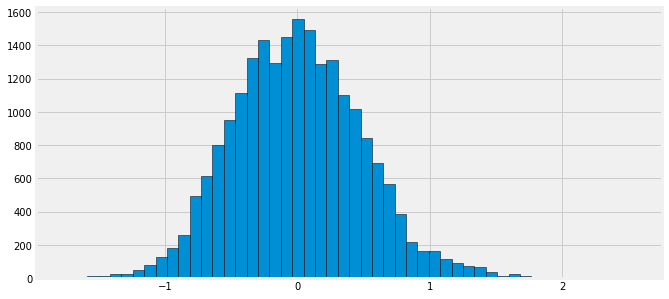

condition
[('Jarque-Bera', 1061.6172589536352), ('Prob', 2.9698962062308685e-231), ('Skew', 0.4264864827576028), ('Kurtosis', 3.6750015964098113)]
Redisuals MIN: -1.72
Redisuals MAX: 2.79


<Figure size 432x288 with 0 Axes>

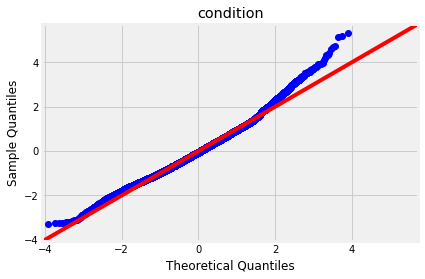

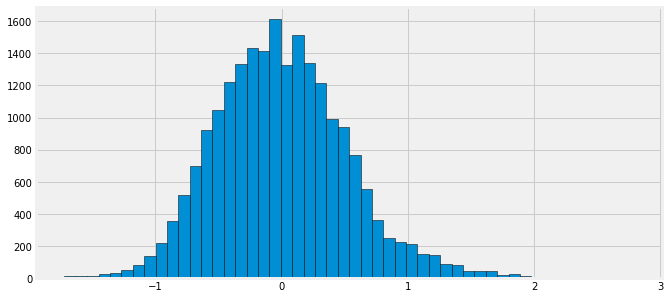

grade
[('Jarque-Bera', 133.75350522975128), ('Prob', 9.032237979159597e-30), ('Skew', 0.18161770213487027), ('Kurtosis', 3.130883689156551)]
Redisuals MIN: -1.43
Redisuals MAX: 1.78


<Figure size 432x288 with 0 Axes>

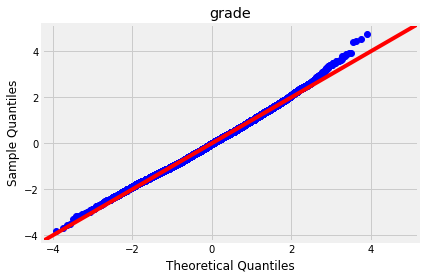

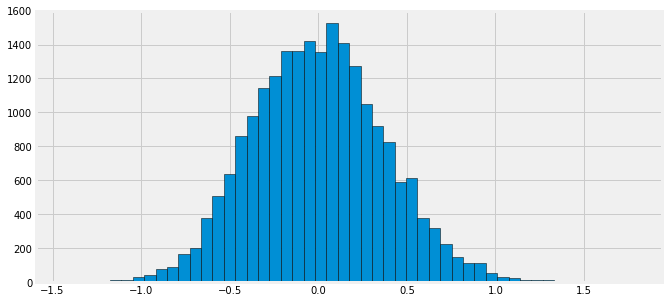

sqft_above
[('Jarque-Bera', 127.49886060941822), ('Prob', 2.0605074741217353e-28), ('Skew', 0.18585723045908747), ('Kurtosis', 2.9373266131043954)]
Redisuals MIN: -1.4
Redisuals MAX: 1.81


<Figure size 432x288 with 0 Axes>

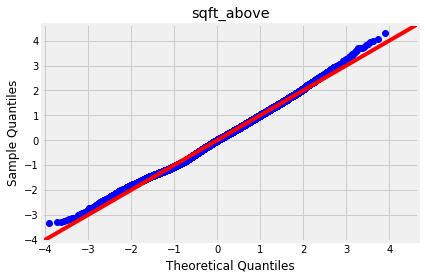

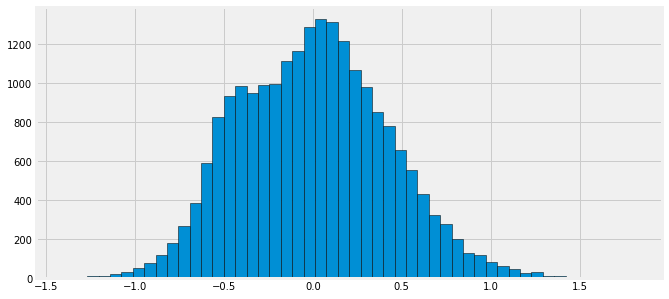

sqft_basement
[('Jarque-Bera', 692.2078564936772), ('Prob', 4.886228779733015e-151), ('Skew', 0.37818265577452237), ('Kurtosis', 3.446529559234162)]
Redisuals MIN: -1.67
Redisuals MAX: 2.42


<Figure size 432x288 with 0 Axes>

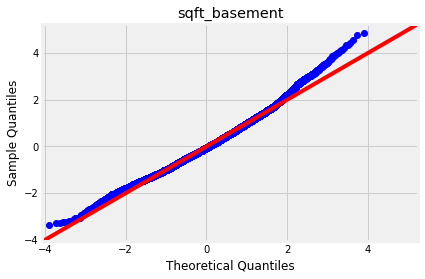

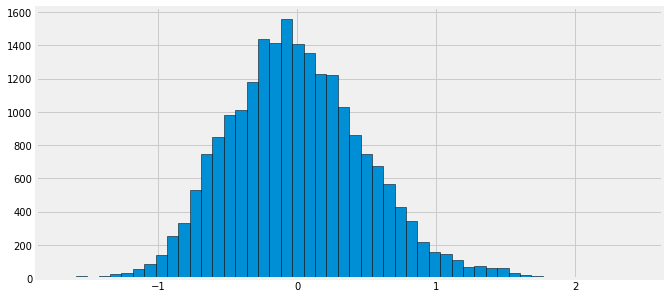

sqft_living15
[('Jarque-Bera', 450.95611239781636), ('Prob', 1.1915832851285467e-98), ('Skew', 0.28616315238965817), ('Kurtosis', 3.4183786135442547)]
Redisuals MIN: -1.89
Redisuals MAX: 1.95


<Figure size 432x288 with 0 Axes>

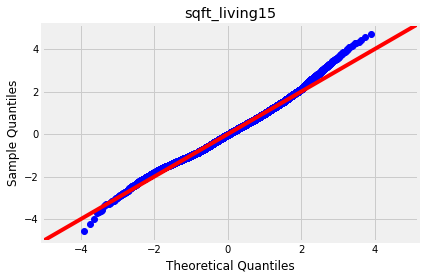

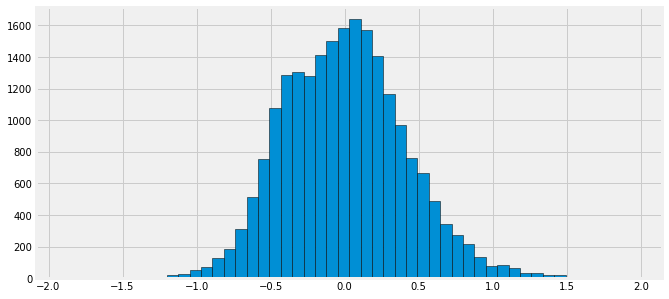

sqft_lot15
[('Jarque-Bera', 1060.978592042642), ('Prob', 4.0872013130914044e-231), ('Skew', 0.4239161690531834), ('Kurtosis', 3.680924780468658)]
Redisuals MIN: -1.81
Redisuals MAX: 2.82


<Figure size 432x288 with 0 Axes>

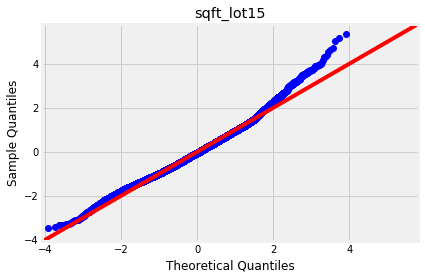

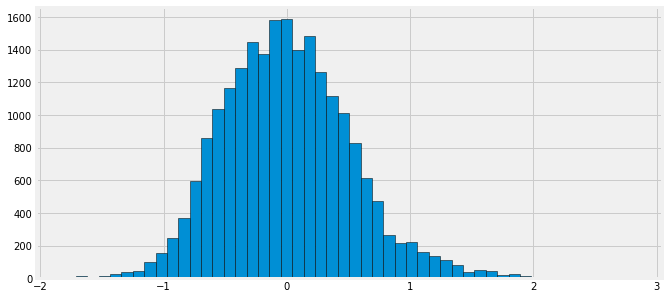

In [22]:
# Normality check using log transformation of target variable 'price'
#Create df with log-transformed 'price'
df_2 = df_1.drop(['price'], axis=1)
df_2['price'] = np.log(df['price'])

#conduct normality check
normality_check(df_2)

In [23]:
# #plotting selected variables
# for col in df_1.drop('price', axis=1):
#     sns.jointplot(col,'price',data=df,kind='reg')
#     plt.show()

---

## Initial Multiple Linear Regression Model

**Initial model with all variables positively correlated with target ('price')**

In [24]:
#sklearn linear regression
linreg_summary(df_2)

R^2: 0.5995176293225246
MSE: 0.11164600531120575
RMSE: 0.33413471132345074
MAE: 0.27085347864209874
TRAIN_MSE: 0.11019184216282482


**Not a big difference between test MSE and TRAIN MSE which is good.** <br/>
**A big difference is an indication overfitting.**

CV 5-Fold MSE: 0.11087504601409184
CV 10-Fold MSE: 0.11088117893768715
CV 20-Fold MSE: 0.11074010568672377


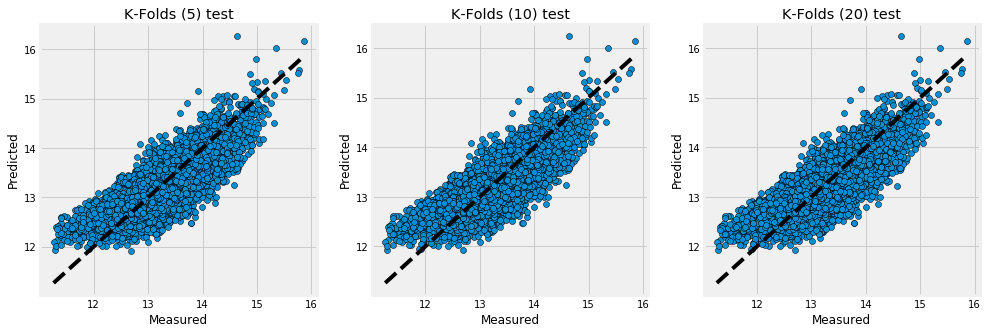

In [25]:
#conduct k-folds cross validation and a visualization of obtained predictions 
k_folds_cv(df_2)

In [26]:
#statsmodels OLS version to see p_values and adjusted R^2
ols_linreg_summary(df_2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     2704.
Date:                Wed, 11 Sep 2019   Prob (F-statistic):               0.00
Time:                        15:39:58   Log-Likelihood:                -6835.1
No. Observations:               21534   AIC:                         1.370e+04
Df Residuals:                   21521   BIC:                         1.380e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            10.8066      0.025    427.748      0.000      10.757      10.856
bedrooms         -0.0161      0.003     -5.126      0.000      -0.022      -0.010
bathrooms        -0.0147      0.005     -2.920      0.004      -0.025      -0.005
sqft_living       0.0001    3.7e-06     35.959      0.000       0.000       0.000
sqft_lot       2.676e-07   7.89e-08      3.390      0.001    1.13e-07    4.22e-07
floors            0.0763      0.006     13.218      0.000       0.065       0.088
waterfront        0.3626      0.030     12.066      0.000       0.304       0.421
view              0.0652      0.003     18.968      0.000       0.059       0.072
condition         0.0954      0.004     26.068      0.000       0.088       0.103
grade             0.1796      0.003     52.293      0.000       0.173       0.186
sqft_above     3.943e-06   3.63e-06      1.086      0.277   -3.17e-06    1.11e-05
sqft_basement     0.0001   4.23e-06     30.452      0.000       0.000       0.000
sqft_living15  9.095e-05   5.53e-06     16.437      0.000    8.01e-05       0.000
sqft_lot15    -8.442e-07   1.21e-07     -7.002      0.000   -1.08e-06   -6.08e-07
==============================================================================
Omnibus:                        5.721   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                5.711
Skew:                           0.034   Prob(JB):                       0.0575
Kurtosis:                       2.957   Cond. No.                     3.40e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.75e-20. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

---

**Next model:**
1. Remove independent variables with p-value above of 0.05 ('sqft_above')
2. Remove independent variables that are highly correlated with each other

---

## Multicollinearity Check

**Correlation with an absolute value around 0.7-0.8 or higher is considered a high correlation. <br/>
I will remove independant variables that are highly correlated with each other.**

In [27]:
df_2.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,price
bedrooms,1.000000,0.514368,0.577934,0.032735,0.177391,-0.003733,0.078523,0.026402,0.356095,0.479148,0.302149,0.392874,0.030952,0.342790
bathrooms,0.514368,1.000000,0.755277,0.088921,0.502285,0.061115,0.186451,-0.126682,0.665312,0.686173,0.282563,0.569139,0.088854,0.550788
sqft_living,0.577934,0.755277,1.000000,0.173768,0.353529,0.101982,0.282532,-0.059783,0.762398,0.876553,0.433930,0.756208,0.184801,0.694786
sqft_lot,0.032735,0.088921,0.173768,1.000000,-0.005025,0.021465,0.075298,-0.008375,0.115122,0.184325,0.015487,0.145142,0.717095,0.100142
floors,0.177391,0.502285,0.353529,-0.005025,1.000000,0.020357,0.028436,-0.264138,0.458694,0.523367,-0.246203,0.279176,-0.010850,0.310492
waterfront,-0.003733,0.061115,0.101982,0.021465,0.020357,1.000000,0.382000,0.016224,0.081195,0.069931,0.080684,0.082352,0.030605,0.169036
view,0.078523,0.186451,0.282532,0.075298,0.028436,0.382000,1.000000,0.045735,0.249727,0.166299,0.274887,0.279561,0.073332,0.345466
condition,0.026402,-0.126682,-0.059783,-0.008375,-0.264138,0.016224,0.045735,1.000000,-0.147326,-0.158830,0.173279,-0.093172,-0.002702,0.038400
grade,0.356095,0.665312,0.762398,0.115122,0.458694,0.081195,0.249727,-0.147326,1.000000,0.755977,0.166673,0.713462,0.121435,0.703402
sqft_above,0.479148,0.686173,0.876553,0.184325,0.523367,0.069931,0.166299,-0.158830,0.755977,1.000000,-0.053268,0.731543,0.195413,0.601490


In [28]:
#check to see which independant variables have corraletion greater than 0.8
abs(df_2.corr()) > 0.8

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,price
bedrooms,True,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,True,False,False,False,False,False,False,True,False,False,False,False
sqft_lot,False,False,False,True,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,True,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,True,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,True,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,True,False,False,False,False,False,False
grade,False,False,False,False,False,False,False,False,True,False,False,False,False,False
sqft_above,False,False,True,False,False,False,False,False,False,True,False,False,False,False


**Independant Variables Highly Correlated with each other** <br/>
sqft_living - sqft_above <br/>
sqft_above - sqft_living <br/>

**I will drop 'sqft_above' because it has a p-value above threshold of 0.05 AND it is highly correlated with 'sqft_living'.**

---

## Second Multiple Linear Regression Model

In [29]:
#Create new df for second model
df_3 = df_2.drop(['sqft_above'], axis=1)

In [30]:
linreg_summary(df_3)

R^2: 0.5995176293225191
MSE: 0.1116460053112073
RMSE: 0.33413471132345307
MAE: 0.2708534786421
TRAIN_MSE: 0.11019184216282482


CV 5-Fold MSE: 0.11087504601409129
CV 10-Fold MSE: 0.11088117893768708
CV 20-Fold MSE: 0.11074010568672357


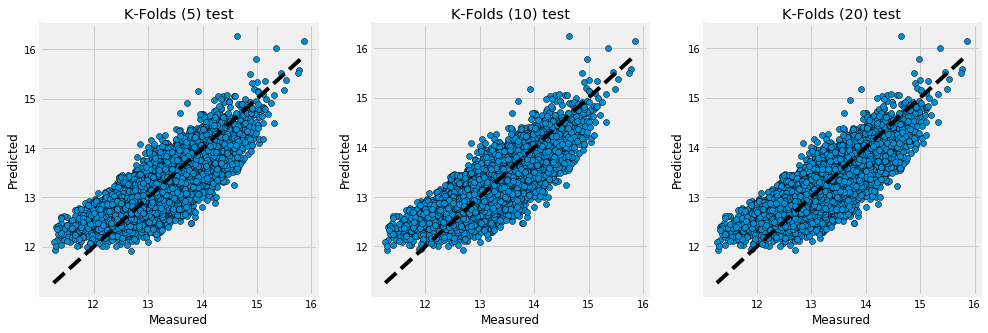

In [31]:
k_folds_cv(df_3)

In [32]:
ols_linreg_summary(df_3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     2704.
Date:                Wed, 11 Sep 2019   Prob (F-statistic):               0.00
Time:                        15:40:55   Log-Likelihood:                -6835.1
No. Observations:               21534   AIC:                         1.370e+04
Df Residuals:                   21521   BIC:                         1.380e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            10.8066      0.025    427.748      0.000      10.757      10.856
bedrooms         -0.0161      0.003     -5.126      0.000      -0.022      -0.010
bathrooms        -0.0147      0.005     -2.920      0.004      -0.025      -0.005
sqft_living       0.0001   5.98e-06     22.887      0.000       0.000       0.000
sqft_lot       2.676e-07   7.89e-08      3.390      0.001    1.13e-07    4.22e-07
floors            0.0763      0.006     13.218      0.000       0.065       0.088
waterfront        0.3626      0.030     12.066      0.000       0.304       0.421
view              0.0652      0.003     18.968      0.000       0.059       0.072
condition         0.0954      0.004     26.068      0.000       0.088       0.103
grade             0.1796      0.003     52.293      0.000       0.173       0.186
sqft_basement     0.0001   6.97e-06     17.938      0.000       0.000       0.000
sqft_living15  9.095e-05   5.53e-06     16.437      0.000    8.01e-05       0.000
sqft_lot15    -8.442e-07   1.21e-07     -7.002      0.000   -1.08e-06   -6.08e-07
==============================================================================
Omnibus:                        5.721   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                5.711
Skew:                           0.034   Prob(JB):                       0.0575
Kurtosis:                       2.957   Cond. No.                     6.71e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---

**Next model:**
1. Min-max scale variables with high magnitudes
2. Create dummy variables for columns with few value counts
3. Decide how to deal with outliers

---

## Log Transformation

In [ ]:
# print(len(df_log.columns))
# print(df_log.columns)

In [ ]:
# df_log1 = pd.DataFrame([])
# df_log1['bathrooms'] = np.log(df_log['bathrooms'])
# df_log1['bedrooms'] = np.log(df_log['bedrooms'])
# df_log1['sqft_living'] = np.log(df_log['sqft_living'])
# df_log1['sqft_lot'] = np.log(df_log['sqft_lot'])
# df_log1['sqft_living15'] = np.log(df_log['sqft_living15'])
# df_log1['sqft_lot15'] = np.log(df_log['sqft_lot15'])


# #
# df_log1['price'] = df_log['price']
# df_log1['floors'] = df_log['floors']
# df_log1['grade'] = df_log['grade']
# df_log1['waterfront'] = df_log['waterfront']
# df_log1['sqft_basement'] = df_log['sqft_basement']
# df_log1['view'] = df_log['view']
# df_log1['condition'] = df_log['condition']

In [ ]:
# len(df_log1.columns)